In [1]:
import sys, os
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import re
import json
from api_keys import vacation_key, geo_key
import numpy as np
import requests
from pprint import pprint
import gmaps

In [2]:
# reading mask coverage data by county
df = pd.read_csv(r'Resources\mandates_by_county.csv')

df

,state,county,statefips,countyfips,maskdays,days,maskcoverage
0,AL,Autauga County,1,1,267,493,0.54
1,AL,Baldwin County,1,3,267,493,0.54
2,AL,Barbour County,1,5,267,493,0.54
3,AL,Bibb County,1,7,267,493,0.54
4,AL,Blount County,1,9,267,493,0.54
...,...,...,...,...,...,...,...
3228,PR,Villalba Municipio,72,149,490,493,0.99
3229,PR,Yabucoa Municipio,72,151,490,493,0.99
3230,PR,Yauco Municipio,72,153,490,493,0.99
3231,VI,St. Croix Island,78,10,469,493,0.95


In [3]:
# only need run once for geocoding
# url = f'http://api.positionstack.com/v1/forward?access_key={geo_key}&query={{}}'

# with open(r'Resources\mandates_by_county_geocode.csv', 'w') as fw:
#     print(f'state,county,lat,lon,statefips,countyfips,maskdays,days,maskcoverage', file=fw)
    
#     for index, row in df.iterrows():
#     #     print(index, list(row))
#         state = row[0]
#         county = row[1].replace(' ', '%20')
#         ctyst = f'{county},%20{state}'

#         url1 = url.format(ctyst)
#     #     print(url1)
#         r = requests.get(url1)
#         dicy = r.json()
#     #     pprint(dicy)

#         lat = dicy['data'][0]['latitude']
#         lon = dicy['data'][0]['longitude']

#         df.loc[index, 'lat'] = lat
#         df.loc[index, 'lon'] = lon

#         print(f'{row[0]}, {row[1]}, {lat}, {lon}, {row[2]}, {row[3]}, {row[4]}, {row[5]}, {row[6]}', file=fw)
#         print(f'{row[0]}, {row[1]}, {lat}, {lon}, {row[2]}, {row[3]}, {row[4]}, {row[5]}, {row[6]}')

In [4]:
# read from stored output so only need geocode once
df = pd.read_csv(r'Resources\mandates_by_county_geocode.csv')

df

,state,county,lat,lon,statefips,countyfips,maskdays,days,maskcoverage
0,AL,Autauga County,32.554052,-86.612433,1,1,267,493,0.54
1,AL,Baldwin County,30.555224,-87.722616,1,3,267,493,0.54
2,AL,Barbour County,31.886628,-85.316973,1,5,267,493,0.54
3,AL,Bibb County,32.999816,-87.099134,1,7,267,493,0.54
4,AL,Blount County,33.957341,-86.562434,1,9,267,493,0.54
...,...,...,...,...,...,...,...,...,...
3228,PR,Villalba Municipio,18.127288,-66.476973,72,149,490,493,0.99
3229,PR,Yabucoa Municipio,18.046734,-65.878242,72,151,490,493,0.99
3230,PR,Yauco Municipio,18.032586,-66.863306,72,153,490,493,0.99
3231,VI,St. Croix Island,17.746706,-64.779172,78,10,469,493,0.95


In [5]:
gmaps.configure(api_key=vacation_key)

locs = df[['lat', 'lon']]
maskdays = df['maskdays'] 

fig = gmaps.figure()

# add heat layer and set max intensity to max mask days
heat = gmaps.heatmap_layer(locs, weights=maskdays, dissipating=False, max_intensity=maskdays.max(), point_radius = 0.6)
fig.add_layer(heat)

fig

Figure(layout=FigureLayout(height='420px'))

In [6]:
# format columns and for merge
df['statefips'] = df['statefips'].map('{:0>2d}'.format)
df['countyfips'] = df['countyfips'].map('{:0>3d}'.format)
df['countyfips'] = df['statefips'] + df['countyfips']

df = df.drop(columns='statefips')
df['county'] =  df['county'].map(lambda x: x.upper())
                                 
df

,state,county,lat,lon,countyfips,maskdays,days,maskcoverage
0,AL,AUTAUGA COUNTY,32.554052,-86.612433,01001,267,493,0.54
1,AL,BALDWIN COUNTY,30.555224,-87.722616,01003,267,493,0.54
2,AL,BARBOUR COUNTY,31.886628,-85.316973,01005,267,493,0.54
3,AL,BIBB COUNTY,32.999816,-87.099134,01007,267,493,0.54
4,AL,BLOUNT COUNTY,33.957341,-86.562434,01009,267,493,0.54
...,...,...,...,...,...,...,...,...
3228,PR,VILLALBA MUNICIPIO,18.127288,-66.476973,72149,490,493,0.99
3229,PR,YABUCOA MUNICIPIO,18.046734,-65.878242,72151,490,493,0.99
3230,PR,YAUCO MUNICIPIO,18.032586,-66.863306,72153,490,493,0.99
3231,VI,ST. CROIX ISLAND,17.746706,-64.779172,78010,469,493,0.95


In [7]:
# read elections return data by county by year
df1 = pd.read_csv(r'Resources\countypres_2000-2020.csv')

df1

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,7503.0,27770.0,20210622,TOTAL
1,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,OTHER,OTHER,429.0,27770.0,20210622,TOTAL
2,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0,20210622,TOTAL
3,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,24578.0,109679.0,20210622,TOTAL
4,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,OTHER,OTHER,1557.0,109679.0,20210622,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2000,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,OTHER,OTHER,119.0,3226.0,20191203,TOTAL
72613,2000,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,AL GORE,DEMOCRAT,NaN,0.0,20191203,TOTAL
72614,2000,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,GEORGE W. BUSH,REPUBLICAN,NaN,0.0,20191203,TOTAL
72615,2000,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,RALPH NADER,GREEN,NaN,0.0,20191203,TOTAL


In [8]:
# select time frame before covid and after covid for comparison
df1 = df1[df1['year'] > 2015]
# get only democrat and repub rows
df1 = df1[df1['party'] != 'OTHER'].reset_index(drop=True)

df1

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,7503.0,27770.0,20210622,TOTAL
1,2020,ALABAMA,AL,AUTAUGA,1001.0,PRESIDENT,DONALD J TRUMP,REPUBLICAN,19838.0,27770.0,20210622,TOTAL
2,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,24578.0,109679.0,20210622,TOTAL
3,2020,ALABAMA,AL,BALDWIN,1003.0,PRESIDENT,DONALD J TRUMP,REPUBLICAN,83544.0,109679.0,20210622,TOTAL
4,2020,ALABAMA,AL,BARBOUR,1005.0,PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,4816.0,10518.0,20210622,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
24378,2016,ALASKA,AK,DISTRICT 39,2039.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,1405.0,5639.0,20191203,TOTAL
24379,2016,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,HILLARY CLINTON,DEMOCRAT,2338.0,4610.0,20191203,TOTAL
24380,2016,ALASKA,AK,DISTRICT 40,2040.0,PRESIDENT,DONALD TRUMP,REPUBLICAN,1377.0,4610.0,20191203,TOTAL
24381,2016,ALASKA,NaN,DISTRICT 99,2099.0,PRESIDENT,HILLARY CLINTON,DEMOCRAT,274.0,5056.0,20191203,TOTAL


In [9]:
# pick out relevant cols and rename
df2 = df1[['year', 'state_po', 'county_name', 'county_fips', 'party', 'candidatevotes', 'totalvotes']]
df2.columns = ['year', 'state', 'county', 'countyfips', 'party', 'votes', 'totvotes']

df2

,year,state,county,countyfips,party,votes,totvotes
0,2020,AL,AUTAUGA,1001.0,DEMOCRAT,7503.0,27770.0
1,2020,AL,AUTAUGA,1001.0,REPUBLICAN,19838.0,27770.0
2,2020,AL,BALDWIN,1003.0,DEMOCRAT,24578.0,109679.0
3,2020,AL,BALDWIN,1003.0,REPUBLICAN,83544.0,109679.0
4,2020,AL,BARBOUR,1005.0,DEMOCRAT,4816.0,10518.0
...,...,...,...,...,...,...,...
24378,2016,AK,DISTRICT 39,2039.0,REPUBLICAN,1405.0,5639.0
24379,2016,AK,DISTRICT 40,2040.0,DEMOCRAT,2338.0,4610.0
24380,2016,AK,DISTRICT 40,2040.0,REPUBLICAN,1377.0,4610.0
24381,2016,NaN,DISTRICT 99,2099.0,DEMOCRAT,274.0,5056.0


In [10]:
# drop na rows
df2 = df2.dropna().reset_index(drop=True)
# # create proportion of votes var
df2['voteperc'] = df2['votes'] / df2['totvotes']

# format all columns
df2['countyfips'] = df2['countyfips'].map(int).map('{:0>5d}'.format)

df2

,year,state,county,countyfips,party,votes,totvotes,voteperc
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184
1,2020,AL,AUTAUGA,01001,REPUBLICAN,19838.0,27770.0,0.714368
2,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090
3,2020,AL,BALDWIN,01003,REPUBLICAN,83544.0,109679.0,0.761714
4,2020,AL,BARBOUR,01005,DEMOCRAT,4816.0,10518.0,0.457882
...,...,...,...,...,...,...,...,...
24357,2016,AK,DISTRICT 38,02038,REPUBLICAN,1143.0,5095.0,0.224338
24358,2016,AK,DISTRICT 39,02039,DEMOCRAT,3142.0,5639.0,0.557191
24359,2016,AK,DISTRICT 39,02039,REPUBLICAN,1405.0,5639.0,0.249158
24360,2016,AK,DISTRICT 40,02040,DEMOCRAT,2338.0,4610.0,0.507158


In [11]:
df3 = df2.merge(df, how='inner', on=['state', 'countyfips'], suffixes=('','_y'))
df3 = df3.drop(columns='county_y')

df3

,year,state,county,countyfips,party,votes,totvotes,voteperc,lat,lon,maskdays,days,maskcoverage
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184,32.554052,-86.612433,267,493,0.54
1,2020,AL,AUTAUGA,01001,REPUBLICAN,19838.0,27770.0,0.714368,32.554052,-86.612433,267,493,0.54
2,2016,AL,AUTAUGA,01001,DEMOCRAT,5936.0,24973.0,0.237697,32.554052,-86.612433,267,493,0.54
3,2016,AL,AUTAUGA,01001,REPUBLICAN,18172.0,24973.0,0.727666,32.554052,-86.612433,267,493,0.54
4,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090,30.555224,-87.722616,267,493,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24120,2016,WY,WESTON,56045,REPUBLICAN,3033.0,3526.0,0.860182,43.841038,-104.567826,66,493,0.13
24121,2016,CA,SAN JOAQUIN,06077,DEMOCRAT,121124.0,224166.0,0.540332,37.961720,-121.277745,424,493,0.86
24122,2016,CA,SAN JOAQUIN,06077,REPUBLICAN,88936.0,224166.0,0.396742,37.961720,-121.277745,424,493,0.86
24123,2016,DC,DISTRICT OF COLUMBIA,11001,DEMOCRAT,282830.0,311268.0,0.908638,38.912097,-77.014683,386,493,0.78


In [12]:
dfd = df3[df3['party'] == 'DEMOCRAT'].reset_index(drop=True)
dfr = df3[df3['party'] == 'REPUBLICAN'].reset_index(drop=True)

In [29]:
#merge and drop dup cols
dfnew = dfd.merge(dfr, left_index=True, right_index=True, suffixes=('','_y'))
dfnew['dmargin'] = dfnew['voteperc'] - dfnew['voteperc_y']

dfnew

,year,state,county,countyfips,party,votes,totvotes,voteperc,lat,lon,...,party_y,votes_y,totvotes_y,voteperc_y,lat_y,lon_y,maskdays_y,days_y,maskcoverage_y,dmargin
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184,32.554052,-86.612433,...,REPUBLICAN,19838.0,27770.0,0.714368,32.554052,-86.612433,267,493,0.54,-0.444184
1,2016,AL,AUTAUGA,01001,DEMOCRAT,5936.0,24973.0,0.237697,32.554052,-86.612433,...,REPUBLICAN,18172.0,24973.0,0.727666,32.554052,-86.612433,267,493,0.54,-0.489969
2,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090,30.555224,-87.722616,...,REPUBLICAN,83544.0,109679.0,0.761714,30.555224,-87.722616,267,493,0.54,-0.537623
3,2016,AL,BALDWIN,01003,DEMOCRAT,18458.0,95215.0,0.193856,30.555224,-87.722616,...,REPUBLICAN,72883.0,95215.0,0.765457,30.555224,-87.722616,267,493,0.54,-0.571601
4,2020,AL,BARBOUR,01005,DEMOCRAT,4816.0,10518.0,0.457882,31.886628,-85.316973,...,REPUBLICAN,5622.0,10518.0,0.534512,31.886628,-85.316973,267,493,0.54,-0.076631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,2016,WY,WASHAKIE,56043,DEMOCRAT,532.0,3814.0,0.139486,43.916244,-107.538740,...,REPUBLICAN,2911.0,3814.0,0.763241,43.916244,-107.538740,66,493,0.13,-0.623755
8184,2020,WY,WESTON,56045,DEMOCRAT,360.0,3560.0,0.101124,43.841038,-104.567826,...,REPUBLICAN,3107.0,3560.0,0.872753,43.841038,-104.567826,66,493,0.13,-0.771629
8185,2016,WY,WESTON,56045,DEMOCRAT,299.0,3526.0,0.084799,43.841038,-104.567826,...,REPUBLICAN,3033.0,3526.0,0.860182,43.841038,-104.567826,66,493,0.13,-0.775383
8186,2016,CA,SAN JOAQUIN,06077,DEMOCRAT,121124.0,224166.0,0.540332,37.961720,-121.277745,...,REPUBLICAN,88936.0,224166.0,0.396742,37.961720,-121.277745,424,493,0.86,0.143590


In [93]:
#Democrat
dfd2020 = dfnew[dfnew['dmargin'] > 0]

gmaps.configure(api_key=vacation_key)

locs = dfd2020[['lat', 'lon']]
dmargin = dfd2020['dmargin'] * 100
# dfd2020['voteperc_adv'] = (dfd2020['voteperc'] -  dfd2020['voteperc'].mean()) * 100
# locs = dfd2020[dfd2020['voteperc_adv'] > 0][['lat', 'lon']]
# voteperc_adv = dfd2020[dfd2020['voteperc_adv'] > 0]['voteperc_adv'] 

fig = gmaps.figure()

# add heat layer and set max intensity to max mask days
heat = gmaps.heatmap_layer(locs, weights=dmargin, dissipating=False, max_intensity=dmargin.max(), point_radius = 1)
fig.add_layer(heat)

fig

Figure(layout=FigureLayout(height='420px'))

In [109]:
#REPUBLICAN
dfd2016 = dfnew[dfnew['dmargin'] < 0]

gmaps.configure(api_key=vacation_key)

locs = dfd2016[['lat', 'lon']]
dmargin = dfd2016['dmargin'] * 100 * -1
# dfd2016['voteperc_adv'] = (dfd2016['voteperc'] -  dfd2016['voteperc'].mean()) * 100
# locs = dfd2016[dfd2016['voteperc_adv'] > 0][['lat', 'lon']]
# voteperc_adv = dfd2016[dfd2016['voteperc_adv'] > 0]['voteperc_adv'] 

fig = gmaps.figure()

# add heat layer and set max intensity to max mask days
heat = gmaps.heatmap_layer(locs, weights=dmargin, dissipating=False, max_intensity=dmargin.max() * 4, point_radius = 1)
fig.add_layer(heat)

fig

Figure(layout=FigureLayout(height='420px'))

In [66]:
dfnew

,year,state,county,countyfips,party,votes,totvotes,voteperc,lat,lon,...,party_y,votes_y,totvotes_y,voteperc_y,lat_y,lon_y,maskdays_y,days_y,maskcoverage_y,dmargin
0,2020,AL,AUTAUGA,01001,DEMOCRAT,7503.0,27770.0,0.270184,32.554052,-86.612433,...,REPUBLICAN,19838.0,27770.0,0.714368,32.554052,-86.612433,267,493,0.54,-0.444184
1,2016,AL,AUTAUGA,01001,DEMOCRAT,5936.0,24973.0,0.237697,32.554052,-86.612433,...,REPUBLICAN,18172.0,24973.0,0.727666,32.554052,-86.612433,267,493,0.54,-0.489969
2,2020,AL,BALDWIN,01003,DEMOCRAT,24578.0,109679.0,0.224090,30.555224,-87.722616,...,REPUBLICAN,83544.0,109679.0,0.761714,30.555224,-87.722616,267,493,0.54,-0.537623
3,2016,AL,BALDWIN,01003,DEMOCRAT,18458.0,95215.0,0.193856,30.555224,-87.722616,...,REPUBLICAN,72883.0,95215.0,0.765457,30.555224,-87.722616,267,493,0.54,-0.571601
4,2020,AL,BARBOUR,01005,DEMOCRAT,4816.0,10518.0,0.457882,31.886628,-85.316973,...,REPUBLICAN,5622.0,10518.0,0.534512,31.886628,-85.316973,267,493,0.54,-0.076631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8183,2016,WY,WASHAKIE,56043,DEMOCRAT,532.0,3814.0,0.139486,43.916244,-107.538740,...,REPUBLICAN,2911.0,3814.0,0.763241,43.916244,-107.538740,66,493,0.13,-0.623755
8184,2020,WY,WESTON,56045,DEMOCRAT,360.0,3560.0,0.101124,43.841038,-104.567826,...,REPUBLICAN,3107.0,3560.0,0.872753,43.841038,-104.567826,66,493,0.13,-0.771629
8185,2016,WY,WESTON,56045,DEMOCRAT,299.0,3526.0,0.084799,43.841038,-104.567826,...,REPUBLICAN,3033.0,3526.0,0.860182,43.841038,-104.567826,66,493,0.13,-0.775383
8186,2016,CA,SAN JOAQUIN,06077,DEMOCRAT,121124.0,224166.0,0.540332,37.961720,-121.277745,...,REPUBLICAN,88936.0,224166.0,0.396742,37.961720,-121.277745,424,493,0.86,0.143590


In [60]:
def reg_plot(x_l, y_l):
    x = np.array(x_l)
    y = np.array(y_l)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color='red', label = '{:.2f} * x + {:.2f}'.format(m, b))
    plt.legend()
    
    return m, b

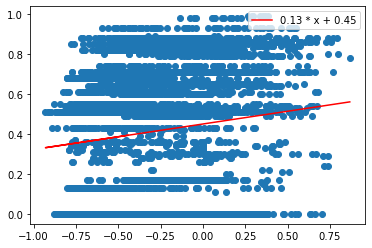

In [67]:
plt.scatter(dfnew['dmargin'], dfnew['maskcoverage'])

corr = reg_plot(dfnew['dmargin'], dfnew['maskcoverage'])

plt.show()

In [112]:
dfnew2020 = dfnew[dfnew['year'] == 2020]
dfnew2016 = dfnew[dfnew['year'] == 2016]

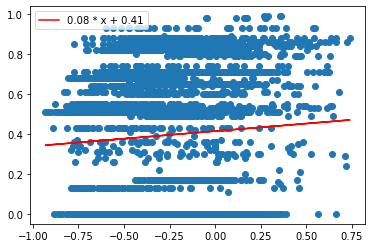

In [113]:
plt.scatter(dfnew2020['dmargin'], dfnew2020['maskcoverage'])

corr = reg_plot(dfnew2020['dmargin'], dfnew2020['maskcoverage'])

plt.show()

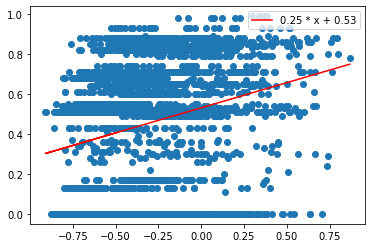

In [114]:
plt.scatter(dfnew2016['dmargin'], dfnew2016['maskcoverage'])

corr = reg_plot(dfnew2016['dmargin'], dfnew2016['maskcoverage'])

plt.show()